In [46]:
import numpy as np
import scipy as sp
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.io import loadmat

In [3]:
calc_df = pd.read_csv('inventory/Calcination curve (Moisture).csv')  
hyd_df = pd.read_csv('inventory/Hydration curves.csv')  
phase_df = pd.read_csv('inventory/Phase content.csv')  

## Calcination Graphs

let's first take a look at these graphs and see how they look like

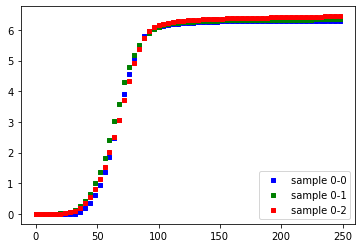

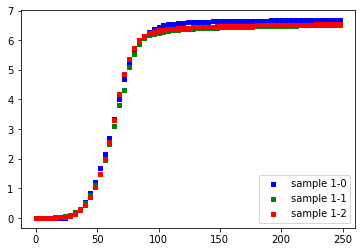

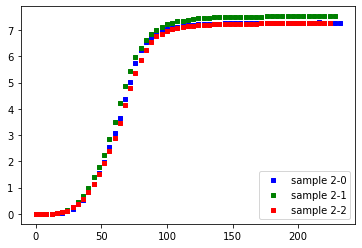

In [15]:
color = ['b', 'g', 'r']
for i in range(3):
    fig = plt.figure()
    for j in range(3):
        x = calc_df['Time']
        y =  calc_df[str(i*3+j+1)]
        plt.scatter(x, y, s=10, c=color[j], marker="s", label='sample {}-{}'.format(i, j))
    plt.legend(loc='lower right')
    plt.show()

### Extract features from calcination graphs

Our finial feature arrayy, X, is an array whose length is equal to the number of our samples. For each sample i, there is a feature matrix X_i of size (X_len, 2). X_i\[:, 0\] is an array extracted from the calcination curve of sample i. Similarly, X_i\[:, 1\] is an array made from hydration curve of sample i.

The calcination feature array for each sample (X_i\[:, 0\]) is made by following steps:

1. Remove leading and tailing plateaus from calcination graphs. This is done by removing points at which the derivative is smaller than 0.001
2. Normalize the graph so x and y ranges become \[0, 1\]
3. Fit a logistic growth curve to the data points
4. Extract X_len points by passing coressponding x values (between 0 and 1) to the fitted curve.

In [76]:
# Logestic Growth function to be fitted on calcination graphs
def logistic(x, a, b, c, d):
    return a / (1. + np.exp(-c * (x - d))) + b

In [108]:
X_len = 10 # length of feature arrays -> number of point to be extracted from the fitted curve
X_calc = np.zeros([X_len, calc_df.shape[1]]) # Feature matrix for calcination curves

# Initiallize values of logistic growth function
a, c = np.random.exponential(size=2)
b, d = np.random.randn(2)

# bounds for curve fitting
bounds = ([0.5, -0.1, 10, 0] , [1.1, 1, 30, 1])

dx = np.diff(calc_df['Time'])
x = calc_df['Time']

sample_num = 0
for col in calc_df.columns[1:]:
    y = calc_df[col]
    dy = np.diff(y)
    dydx = dy / dx
    # keep x and ys that are not in the plateau region of the graph
    new_x = [x[i] for i in range(len(dy)) if (dydx[i] > 0.001)]
    new_y = [y[i] for i in range(len(dy)) if (dydx[i] > 0.001)]

    # normalize x and y.
    new_x /= np.max(new_x)
    new_y /= np.max(new_y) 

    # fit the logistic growth curve
    (a_, b_, c_, d_), _ = sp.optimize.curve_fit(logistic, new_x, new_y, bounds=bounds)

    # Calculating feature array
    x_ = [x/(X_len+1) for x in range(X_len + 2)] 
    y_ = logistic(x_, a_, b_, c_, d_)
    # normalzing the calculated y
    y_n = (y_ - np.min(y_)) / (np.max(y_) - np.min(y_))

    # Save it in the calcination feature matrix. the first and last elements in y_n are 0 and 1 for all samples. So, we drop them.
    X_calc[:, sample_num] = y_n[1:-1]

    # print(a_, b_, c_, d_)
    # plt.scatter(new_x, new_y, s=10, marker="s")
    # plt.plot(new_x, logistic(new_x, a_, b_, c_, d_))

In [107]:
a = [x/11 for x in range(12)]
a[1:-1]

[0.09090909090909091,
 0.18181818181818182,
 0.2727272727272727,
 0.36363636363636365,
 0.45454545454545453,
 0.5454545454545454,
 0.6363636363636364,
 0.7272727272727273,
 0.8181818181818182,
 0.9090909090909091]